<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required libraries

In [1]:
pip install pyLDAvis


     |████████████████████████████████| 1.7 MB 12.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e07c4ca4084d64a3d889ccdc74c3e1ae2646cfca29f766e9d56e79d65dba4a37
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [38]:
import re
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string


#for histogram
import matplotlib.pyplot as plt
from collections import Counter

#nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


#Dataset
from sklearn.datasets import fetch_20newsgroups

#Spacy
import spacy
nlp = spacy.load('en_core_web_sm')

#Visuals
import pyLDAvis
import pyLDAvis.gensim_models

#warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data into Dataframe

In [72]:
#method that converts data to csv file
def twenty_newsgroup_data_to_csv():
    news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

    df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
    df.columns = ['text', 'target']

    targets = pd.DataFrame( news_group_data.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out.to_csv('20_newsgroup.csv')
twenty_newsgroup_data_to_csv()


In [73]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)
    



In [74]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1471
text          1471
target        1471
title         1471
dtype: int64


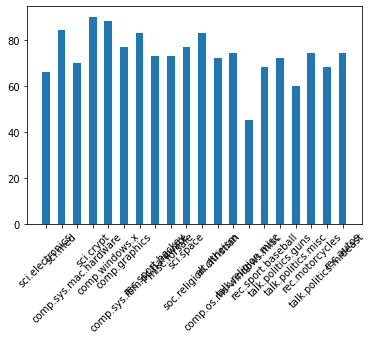

In [75]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [76]:
print(counter)

Counter({'sci.crypt': 90, 'comp.windows.x': 88, 'sci.med': 84, 'comp.sys.ibm.pc.hardware': 83, 'soc.religion.christian': 83, 'comp.graphics': 77, 'sci.space': 77, 'comp.os.ms-windows.misc': 74, 'rec.motorcycles': 74, 'rec.autos': 74, 'rec.sport.hockey': 73, 'misc.forsale': 73, 'alt.atheism': 72, 'talk.politics.guns': 72, 'comp.sys.mac.hardware': 70, 'rec.sport.baseball': 68, 'talk.politics.mideast': 68, 'sci.electronics': 66, 'talk.politics.misc': 60, 'talk.religion.misc': 45})


### Pre-process data

Lemmatization to get base words

In [77]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)
 

In [78]:
dataset['news_cleaned_text']=lemmatization(dataset['text'])


In [79]:
print(dataset.head())


   Unnamed: 0                                               text  target  \
0        3292  \nNo flames please, but I picked up this discu...      12   
1        9542  I got a question from my dad which I really ca...      12   
2        8049  \nFor some reason the name Grayhill springs to...      12   
3        9547  \nGee, I got the idea from somewhere that devi...      12   
4        6161                  I'll bet there's a runway nearby.      12   

             title                                  news_cleaned_text  
0  sci.electronics  flame pick discussion bit late really curious ...  
1  sci.electronics  get question dad really can answer would appre...  
2  sci.electronics  reason name spring mind see catalog option cus...  
3  sci.electronics  get idea somewhere device common use commander...  
4  sci.electronics                             will bet runway nearby  


Remove Stopwords

In [70]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [80]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_cleaned_text'])


In [81]:
print(dataset.head())

   Unnamed: 0                                               text  target  \
0        3292  \nNo flames please, but I picked up this discu...      12   
1        9542  I got a question from my dad which I really ca...      12   
2        8049  \nFor some reason the name Grayhill springs to...      12   
3        9547  \nGee, I got the idea from somewhere that devi...      12   
4        6161                  I'll bet there's a runway nearby.      12   

             title                                  news_cleaned_text  \
0  sci.electronics  flame pick discussion bit late really curious ...   
1  sci.electronics  get question dad really can answer would appre...   
2  sci.electronics  reason name spring mind see catalog option cus...   
3  sci.electronics  get idea somewhere device common use commander...   
4  sci.electronics                             will bet runway nearby   

                                         news_tokens  
0  [flame, pick, discussion, bit, late, really, c

## Bag of words

In [143]:
#id2word
data_word = dataset['news_tokens']
id2word = corpora.Dictionary(data_word)
corpus = []
for text in data_word:
  new = id2word.doc2bow(text)
  corpus.append(new)

#id and frequency of word
print ("Dictionary for doc 9" ,corpus[9])
print ("Dictionary for doc 176" ,corpus[176])


Dictionary for doc 7 [(37, 1), (96, 1), (280, 1), (281, 1), (282, 1), (283, 1), (284, 1), (285, 1), (286, 1), (287, 1), (288, 1), (289, 1), (290, 1), (291, 1), (292, 2), (293, 1), (294, 1), (295, 1), (296, 1), (297, 1), (298, 1), (299, 1), (300, 1), (301, 1), (302, 1), (303, 1), (304, 1), (305, 1)]
Dictionary for doc 176 [(44, 1), (59, 1), (96, 1), (294, 1), (298, 1), (313, 1), (426, 1), (549, 1), (610, 1), (620, 1), (946, 1), (1036, 1), (2588, 1), (2724, 1), (2725, 1), (2726, 1)]


In [146]:
word = id2word[298]
print(word)

recall


## Build LDA Model

In [151]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], id2word = id2word, num_topics = 20, random_state = 100, update_every=1, chunksize=100, passes = 10, alpha="auto")

In [152]:
test_doc = corpus[-1]
vector = lda_model[test_doc]
print(vector)

# sort by match f
def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return(sub_li)
new_vector = Sort(vector)
print(new_vector)



[(0, 0.044190012), (1, 0.055698104), (2, 0.012072348), (4, 0.039845243), (5, 0.11031731), (6, 0.08834165), (7, 0.20973796), (9, 0.11441303), (11, 0.1858238), (12, 0.03087611), (13, 0.010315255), (16, 0.017091902), (18, 0.015008173), (19, 0.022420712)]
[(7, 0.20973796), (11, 0.1858238), (9, 0.11441303), (5, 0.11031731), (6, 0.08834165), (1, 0.055698104), (0, 0.044190012), (4, 0.039845243), (12, 0.03087611), (19, 0.022420712), (16, 0.017091902), (18, 0.015008173), (2, 0.012072348), (13, 0.010315255)]


## Visualise Data

In [153]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.435840 -0.146829       1        1  15.917272
6     -0.425852  0.040696       2        1  12.188984
11    -0.292443 -0.347304       3        1  11.110489
12    -0.075970 -0.422033       4        1   6.436468
1     -0.070941  0.440553       5        1   6.323569
16    -0.277056  0.349838       6        1   5.438781
19    -0.323051  0.166968       7        1   5.158407
5     -0.247081 -0.173741       8        1   4.961698
7      0.055406 -0.366926       9        1   4.907028
8      0.355202 -0.197549      10        1   3.941599
18     0.225320 -0.354713      11        1   3.897771
13     0.261433  0.351074      12        1   3.052910
0     -0.070503 -0.038062      13        1   2.645884
10     0.088719  0.043782      14        1   2.529976
2     -0.078866  0.239270      15        1   2.393986
4      0.107199  0.303293      16        1   1.969877
3      0.193350 -0.128593      17        1   1.943876
14     0.417729 -0.011963      18        1   1.925897
17     0.292387  0.061207      19        1   1.655635
15     0.300857  0.191032      20        1   1.599893, topic_info=          Term        Freq       Total Category  logprob  loglift
6018        ax  433.000000  433.000000  Default  10.0000  10.0000
102        say  988.000000  988.000000  Default   9.0000   9.0000
130         go  806.000000  806.000000  Default   8.0000   8.0000
99      people  759.000000  759.000000  Default   7.0000   7.0000
771        car  324.000000  324.000000  Default   6.0000   6.0000
...        ...         ...         ...      ...      ...      ...
1239    strong   25.366128   26.164104  Topic20  -4.2302   4.1043
4533      tape   20.362100   21.160076  Topic20  -4.4500   4.0968
904   anywhere   20.067708   20.865684  Topic20  -4.4645   4.0962
152      drive   43.201419  220.423217  Topic20  -3.6978   2.5056
405      datum   20.936543   43.169014  Topic20  -4.4222   3.4116

[312 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1081     13  0.118917       able
1081     18  0.866393       able
2814      4  0.987780     action
2005      3  0.990761      agree
1197     17  0.979847        aid
...     ...       ...        ...
279       1  0.264445       year
279       4  0.103479       year
279       6  0.629495       year
7097     10  0.992647  yesterday
1422     15  0.992754      young

[482 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 12, 13, 2, 17, 20, 6, 8, 9, 19, 14, 1, 11, 3, 5, 4, 15, 18, 16])

In [154]:
for i in range(0, lda_model.num_topics-1):
  print (lda_model.print_topic(i))

0.033*"window" + 0.024*"automatic" + 0.020*"work" + 0.017*"forget" + 0.014*"office" + 0.014*"interest" + 0.013*"product" + 0.013*"resource" + 0.012*"widget" + 0.012*"willing"
0.050*"say" + 0.048*"go" + 0.021*"live" + 0.021*"gun" + 0.019*"time" + 0.017*"hear" + 0.013*"start" + 0.013*"maybe" + 0.013*"people" + 0.011*"rather"
0.036*"stand" + 0.036*"return" + 0.034*"important" + 0.034*"young" + 0.027*"building" + 0.026*"history" + 0.025*"non" + 0.020*"reference" + 0.013*"manual" + 0.013*"standard"
0.090*"kill" + 0.059*"child" + 0.027*"plan" + 0.020*"table" + 0.019*"charge" + 0.016*"clearly" + 0.015*"depend" + 0.014*"clock" + 0.012*"wear" + 0.012*"aid"
0.062*"armenian" + 0.033*"turkish" + 0.021*"single" + 0.016*"gas" + 0.014*"wheel" + 0.013*"save" + 0.011*"german" + 0.010*"shall" + 0.010*"border" + 0.009*"escape"
0.060*"car" + 0.031*"thank" + 0.025*"old" + 0.023*"find" + 0.019*"know" + 0.019*"tell" + 0.019*"school" + 0.018*"book" + 0.017*"look" + 0.016*"back"
0.022*"may" + 0.019*"change" + 